# This notebook perofms a case study comparing GPROF V7, ERA5, and the SatRain retrievals


In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from typing import Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

## GPROF


In [3]:
def load_gprof_precip(path: Path, scan_start: int, scan_end: int) -> xr.Dataset:
    """
    Load GPROF precipitation.

    Args:
        path: A Path object pointing to the IMERG file to load.
        scan_start: The start scan of the collocation.
        scan_end: Index pointing to the first scan that is not part of 
             the collocation anymore.

    Return:
        An xarray.Dataset containing the 'surface_precip', 'probability_of_precip',
        'precipitation_flag', 'probability_of_heavy_precip', and 'heavy_precip_flag'
        extracted from the GPROF file pointed to by 'path'.
    """
    slc = slice(scan_start, scan_end)
    with h5py.File(path) as data:
        lats = data["S1/Latitude"][slc]
        lons = data["S1/Longitude"][slc]
        
        surface_precip = data["S1/surfacePrecipitation"][slc]
        invalid = surface_precip < 0
        surface_precip[invalid] = np.nan
        probability_of_precip = data["S1/probabilityOfPrecip"][slc] / 100.0
        precipitation_flag = data["S1/precipitationYesNoFlag"][slc]
        probability_of_heavy_precip = np.clip(surface_precip / 100, 0.0, 1.0)

    data.close()
    del data
        
    return xr.Dataset({
        "longitude": (("scan", "pixel"), lons),
        "latitude": (("scan", "pixel"), lats),
        "surface_precip": (("scan", "pixel"), surface_precip),
        "probability_of_precip": (("scan", "pixel"), probability_of_precip),
        "precip_flag": (("scan", "pixel"), precipitation_flag),
        "probability_of_heavy_precip": (("scan", "pixel"), probability_of_heavy_precip),
        "heavy_precip_flag": (("scan", "pixel"), surface_precip > 10),
    })


In [4]:
from pyresample.geometry import SwathDefinition
from pansat.utils import resample_data
from pansat.products.satellite.gpm import l2a_gprof_gpm_gmi_v07a, l2a_gprof_gpm_gmi_v07b

def retrieve_gprof(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval callback function to load GPROF data corresponding to IPWGML SPR evaluation data.

    Args:
        input_data: An xarray.Dataset containing the retrieval input data.

    Return:
        An xarray.Dataset containing the retrieval results.
    """
    time = input_data.time.mean().data
    recs = l2a_gprof_gpm_gmi_v07a.get(time)
    if len(recs) == 0:
        recs = l2a_gprof_gpm_gmi_v07b.get(time)
    rec = recs[0]
    input_file = input_data.attrs["gpm_input_file"]
    scan_start = input_data.attrs["scan_start"]
    scan_end = input_data.attrs["scan_end"]
    results_gprof = load_gprof_precip(rec.local_path, scan_start, scan_end)

    n_batches = input_data.batch.size
    batch_results = []
    for batch_ind in range(n_batches):
        lons = input_data.longitude[batch_ind]
        lats = input_data.latitude[batch_ind]
        lons, lats = np.meshgrid(lons, lats)
        grid = SwathDefinition(lons, lats)
        results_gprof_r = resample_data(results_gprof, grid, radius_of_influence=10e3)
        batch_results.append(results_gprof_r.drop_vars(("latitude", "longitude")))
    return xr.concat(batch_results, dim="batch")

/home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## ERA5


In [5]:
from satrain.input import Ancillary
anc = Ancillary(variables=["total_precipitation"])

def retrieve_era5(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval callback function to load GPROF data corresponding to IPWGML SPR evaluation data.

    Args:
        input_data: An xarray.Dataset containing the retrieval input data.

    Return:
        An xarray.Dataset containing the retrieval results.
    """
    lons = input_data.longitude.data
    lats = input_data.latitude.data
    tp = input_data.ancillary.data[:, 0]
        
    return xr.Dataset({
        "surface_precip": (("batch", "latitude", "longitude"), tp * 1e3),
    })

[14:45:32] INFO     blosc filter already loaded, skip it.                                             ]8;id=962279;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py\_utils.py]8;;\:]8;id=16131;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py#250\250]8;;\

           INFO     bzip2 filter already loaded, skip it.                                             ]8;id=958905;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py\_utils.py]8;;\:]8;id=609569;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py#250\250]8;;\

           INFO     zstd filter already loaded, skip it.                                              ]8;id=123629;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py\_utils.py]8;;\:]8;id=506953;file:///home/simon/miniforge3/envs/satrain/lib/python3.13/site-packages/hdf5plugin/_utils.py#250\250]8;;\

## SatRain retrievals

In [6]:
from pytorch_retrieve import load_model
model_gmi = load_model("/home/simon/src/ipwgml/models/satrain/gmi/ipwgml_gmi.pt")
model_geo = load_model("/home/simon/src/ipwgml/models/satrain/geo/checkpoints/ipwgml_geo-v3.ckpt")
model_geo_ir = load_model("/home/simon/src/ipwgml/models/satrain/geo_ir/ipwgml_geo_ir.pt")

In [7]:
from typing import Any, List, Dict
import torch
from torch import nn
import xarray as xr

from satrain.input import calculate_input_features

class PytorchRetrieval:
    """
    This class provides a generic retrieval callback function for PyTorch-based
    retrievals.

    The PytorchRetrieval wraps around a torch.nn.Module and extracts the input
    data from the xarray.Dataset provided by the ipwgml.evaluation.Evaluator
    and feeds it into the module. It then transform the output back from
    PyTorch tensors to an xarray.Dataset containing the retrieval results.

    The PytorchRetrieval class expects the module to return a dict containing
    the keys 'surface_precip', 'probability_of_precip', and
    'probability_of_heavy_precip'.
    """
    def __init__(
            self,
            model: nn.Module,
            retrieval_input: List[str | Dict[str, Any]],
            precip_threshold: float = 0.5,
            heavy_precip_threshold: float = 0.5,
            stack: bool = False,
            logits: bool = True,
            device: torch.device = torch.device("cpu"),
            dtype: torch.dtype = torch.float32,
    ):
        """
        Args:
            model: A torch.nn.Module implementing the retrieval.
            retrieval_input: A list defining the retrieval input.
            precip_threshold: The probability threshold to apply to
                transform the 'probability_of_precip' to a 'precip_flag'
                output.
            heavy_precip_threshold: Same as 'precip_threshold' but for
                heavy precip flag output.
            stack: Whether or not the model expects the input data to
                be stacked ('True') or as dictionary.
            logits: Whether the model returns logits instead of probabilities.
            device: A torch.device defining the device on which to perform
                inference.
            dtype: The dtype to which to convert the retrieval input.
        """
        self.model = model.to(device=device).eval()
        self.features = calculate_input_features(retrieval_input, stack=False)
        self.precip_threshold = precip_threshold
        self.heavy_precip_threshold = heavy_precip_threshold
        self.stack = stack
        self.logits = logits
        self.device = device
        self.dtype = dtype

    def __call__(self, input_data: xr.Dataset) -> xr.Dataset:
        """
        Run retrieval on input data.
        """
        feature_dim = 0
        if "scan" in input_data.dims:
            spatial_dims = ("scan", "pixel")
        elif "latitude" in input_data.dims:
            spatial_dims = ("latitude", "longitude")
        else:
            spatial_dims = ()

        if "batch" in input_data.dims:
            dims = ("batch",) + spatial_dims
            feature_dim += 1
        else:
            dims = spatial_dims


        features = self.features
        inpt = {}
        for name in features:
            inpt_data = torch.tensor(input_data[name].data).to(self.device, self.dtype)
            if len(dims) == 1:
                inpt_data = inpt_data.transpose(0, 1)
            inpt[name] = inpt_data

        if self.stack:
            inpt = torch.cat(list(inpt.values()), dim=feature_dim)

        with torch.no_grad():
            pred = self.model(inpt)
            surface_precip = pred["surface_precip"].expected_value().float().cpu().numpy()
            #pop = pred["precip_mask"].probability().float().cpu().numpy()
            #precip_mask = 0.5 < pop 
            #pop_heavy = pred["heavy_precip_mask"].probability().float().cpu().numpy()
            #heavy_precip_mask = 0.5 < pop_heavy
            
            results = xr.Dataset()
            results["surface_precip"] = (dims, surface_precip[:, 0])
            #results["probability_of_precip"] = (dims, pop[:, 0])
            #results["precip_flag"] = (dims, precip_mask[:, 0])
            #results["probability_of_heavy_precip"] = (dims, pop_heavy[:, 0])
            #results["heavy_precip_flag"] = (dims, heavy_precip_mask[:, 0])

        return results


In [8]:
import torch
gmi_retrieval = PytorchRetrieval(
    model_gmi,
    retrieval_input=["gmi"],
    device=torch.device("cuda:1"),
    dtype=torch.float32 
)
geo_retrieval = PytorchRetrieval(
    model_geo,
    retrieval_input=["geo"],
    device=torch.device("cuda:1"),
    dtype=torch.float32 
)
geo_ir_retrieval = PytorchRetrieval(
    model_geo_ir,
    retrieval_input=["geo_ir"],
    device=torch.device("cuda:1"),
    dtype=torch.float32 
)

In [9]:
from satrain.evaluation import Evaluator
from satrain.target import TargetConfig

domain = "korea"
evaluator = Evaluator(
    domain=domain,
    base_sensor="gmi",
    geometry="gridded",
    retrieval_input=[
        {"name": "gmi", "normalize": "minmax", "nan": -2},
        {"name": "geo", "normalize": "minmax", "nan": -2, "channels": [1, 2, 4, 6, 7, 9, 10, 11, 14, 15]},
        {"name": "geo_ir", "normalize": "minmax", "nan": -2},
        {"name": "ancillary", "variables": ["total_precipitation"]},
    ],
    download=True,
)
print(f"Found {len(evaluator)} overpasses.")

600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
600 600
0
Found 600 overpasses.


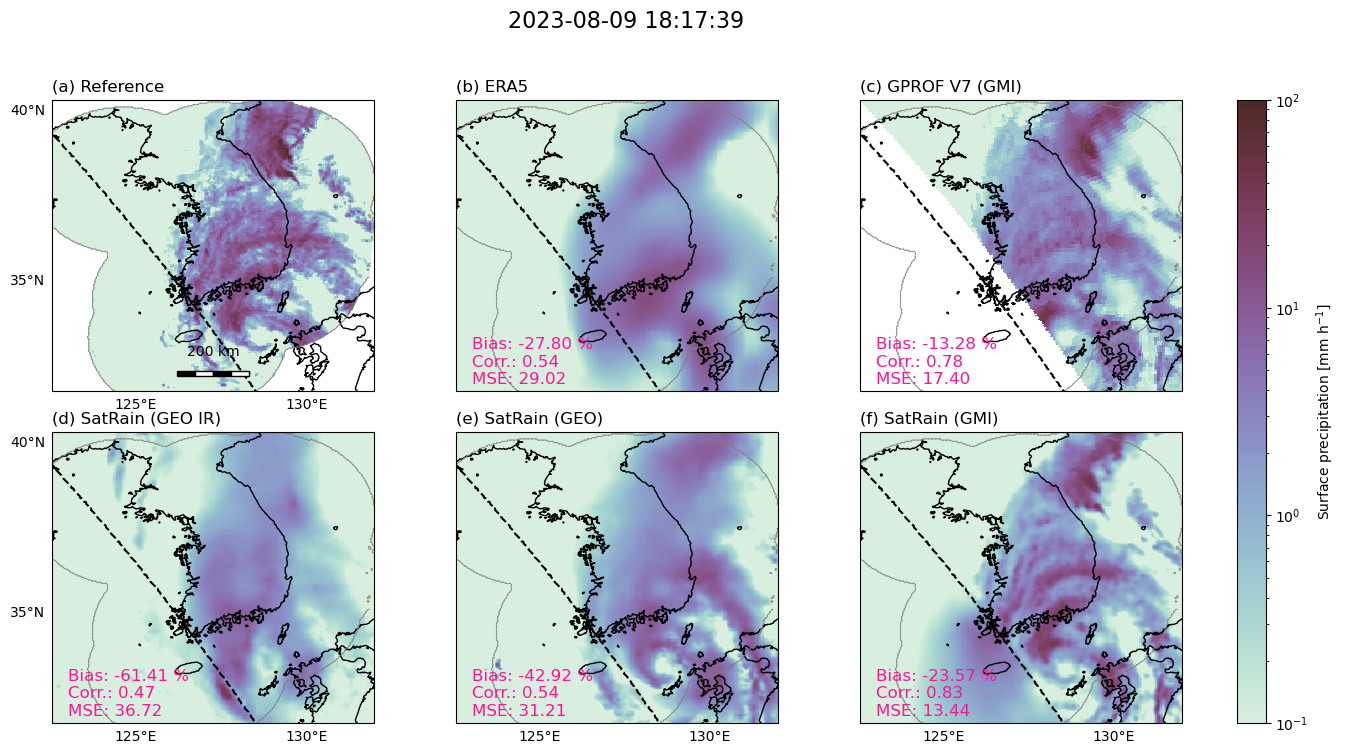

In [11]:
fig = evaluator.plot_retrieval_results(
    516,
    retrieval_fn={
        "ERA5": retrieve_era5,
        "GPROF V7 (GMI)": retrieve_gprof,
        "SatRain (GEO IR)": geo_ir_retrieval,
        "SatRain (GEO)": geo_retrieval,
        "SatRain (GMI)": gmi_retrieval
    },
    include_metrics=True,
    input_data_format="spatial",
    batch_size=32,
    tile_size=(256, 256),
    overlap=64,
    n_rows=2,
    contour_legend=False,
    swath_boundaries=True
)
fig.savefig("../figures/fig09.png", bbox_inches="tight", dpi=200)